In [2]:
import pandas as pd
import numpy as np
import shutil
import os
import random
from PIL import Image
from datasets import load_dataset
import matplotlib.pyplot as plt

In [106]:
data = pd.read_json("../data/annotations.json")

print("Plots Dataset size :", len(data))
data.head()

Plots Dataset size : 33657


,models,type,general_figure_info,image_index
0,"[{'name': 'Goods and services', 'color': '#F0E...",dot_line,{'title': {'text': 'Payments made towards prim...,0
1,"[{'name': 'Arms exports', 'color': '#FFFF00', ...",dot_line,{'title': {'text': 'Arm exports and imports in...,1
2,"[{'name': 'Infant', 'color': '#191970', 'label...",dot_line,{'title': {'text': 'Mortality rates in Marshal...,2
3,"[{'name': 'Female', 'color': '#D2B48C', 'label...",dot_line,{'title': {'text': 'Percentage of repeaters in...,3
4,"[{'name': 'US$', 'color': '#B8860B', 'label': ...",dot_line,{'title': {'text': 'Total resource balance of ...,4


In [107]:
data["type"].value_counts()

type
hbar_categorical    11292
vbar_categorical    11242
dot_line             5574
line                 5549
Name: count, dtype: int64

**Filtro el dataset para quedarme con las visualizaciones single-plot, elimino los hbar plots y renombro los tipos**

In [108]:
single_plots = data[data['models'].apply(lambda x: len(x) == 1)].copy()
single_plots = single_plots.dropna(subset=["type"])

print("Single-plots Dataset size :", len(single_plots))
single_plots.head()

Single-plots Dataset size : 6070


,models,type,general_figure_info,image_index
4435,"[{'name': 'Secure Internet servers', 'color': ...",dot_line,{'title': {'text': 'Number of secure servers i...,4435
4436,"[{'name': 'Communications', 'color': '#FFA07A'...",dot_line,"{'y_axis': {'minor_ticks': {'values': [0, 1, 2...",4436
4437,"[{'name': 'Armed forces personnel', 'color': '...",dot_line,{'title': {'text': 'Total onduty military pers...,4437
4438,[{'name': 'Government expenditure per tertiary...,dot_line,{'title': {'text': 'Government expenditure per...,4438
4439,"[{'name': 'Tax payments', 'color': '#6B8E23', ...",dot_line,"{'y_axis': {'minor_ticks': {'values': [0, 1, 2...",4439


In [109]:
def check_for_quotes(values):

    values_new = []
    
    for val in values:
        if isinstance(val, str):
            if val.find("'") != -1: val = val.replace("'","")

        values_new.append(val)

    return values_new

def var_type(var):

    try:
        float(var)
        return "temporal"
    except:
        return "nominal"

In [110]:
new_df_data = []
indices = []

for idx, row in single_plots.iterrows():

    mark_type, x_type, y_type, x_name, y_name, x_values, y_values = None, None, None, None, None, None, None

    x_name = row["general_figure_info"]["x_axis"]["label"]["text"]
    y_name = row["general_figure_info"]["y_axis"]["label"]["text"]

    x_values = check_for_quotes(row["models"][0]["x"])
    y_values = check_for_quotes(row["models"][0]["y"])

    if row["type"] == "dot_line":
        
        mark_type = "circle"
        
        if x_name == "Year":
            x_values = row["general_figure_info"]["x_axis"]["major_labels"]["values"]
            x_type = "temporal" 
        else:
            x_type = "quantitative"

        y_type = "quantitative"

    elif row["type"] == "vbar_categorical":
        
        mark_type = "bar"

        x_type = var_type(x_values[0])
        y_type = "quantitative"

    elif row["type"] == "hbar_categorical":

        mark_type = "bar"

        x_type = "quantitative"
        y_type = var_type(y_values[0])
        
    elif row["type"] == "line":
        
        mark_type = "line"

        if x_name == "Year":
            x_values = row["general_figure_info"]["x_axis"]["major_labels"]["values"]

        x_type = "temporal"
        y_type = "quantitative"

    new_df_data.append({"mark_type": mark_type,
                        "x_type": x_type,
                        "y_type": y_type,
                        "x_name": x_name,
                        "y_name": y_name,
                        "x_values": x_values,
                        "y_values": y_values})
    
    indices.append(idx)
    
plots = pd.DataFrame(new_df_data, index = indices)

In [111]:
def get_vega(df, index, vega_structure = True):
    
    ''' Get vega code from a PlotQA DataFrame entry at index '''

    mark_type = df["type"][index]

    x_name = df["general_figure_info"][index]["x_axis"]["label"]["text"]
    y_name = df["general_figure_info"][index]["y_axis"]["label"]["text"]

    y_values = [np.round(y, 2) for y in df["models"][index][0]["y"]]
    
    x_values = single_plots["general_figure_info"][index]["x_axis"]["major_labels"]["values"]
    x_values_new = []
    
    for x_val in x_values:
        if isinstance(x_val, str):
            if x_val.find("'") != -1: x_val = x_val.replace("'","")

        x_values_new.append(x_val)

    x_values = x_values_new    

    midpoint = len(x_values) // 2
    x_values = x_values[:midpoint]

    x_type = var_type(x_values[0])
    y_type = var_type(y_values[0])

    vega = None

    if vega_structure:

        vega = {"mark": mark_type,
                "encoding": {
                    "x": {"field": x_name, "type": x_type},
                    "y": {"field": y_name, "type": "quantitative"}
                },
                "data": {
                    "values": [
                        {"x": x, "y": y} for x,y in zip(x_values, y_values)
                    ]
                }
            }
    else:
        vega = mark_type + "|" + x_type + "|" + x_name + "|" + y_type + "|" + y_name

    return vega

In [112]:
def get_vega2(df, index, vega_structure = True):

    mark_type = df["mark_type"][index]

    x_type = df["x_type"][index]
    y_type = df["y_type"][index]

    x_name = df["x_name"][index]
    y_name = df["y_name"][index]

    x_values = df["x_values"][index]
    y_values = df["y_values"][index]

    vega = None

    if vega_structure:

        vega = {"mark": mark_type,
                "encoding": {
                    "x": {"field": x_name, "type": x_type},
                    "y": {"field": y_name, "type": y_type}
                },
                "data": {
                    "values": [
                        {"x": x, "y": y} for x,y in zip(x_values, y_values)
                    ]
                }
            }
    else:
        vega = mark_type + "|" + x_type + "|" + x_name + "|" + y_type + "|" + y_name

    return vega

In [113]:
index = plots.sample().index[0]
get_vega2(plots, index)

{'mark': 'line',
 'encoding': {'x': {'field': 'Year', 'type': 'temporal'},
  'y': {'field': 'Time spent(% of senior management time)',
   'type': 'quantitative'}},
 'data': {'values': [{'x': '2010', 'y': 11.8}, {'x': '2013', 'y': 1.9}]}}

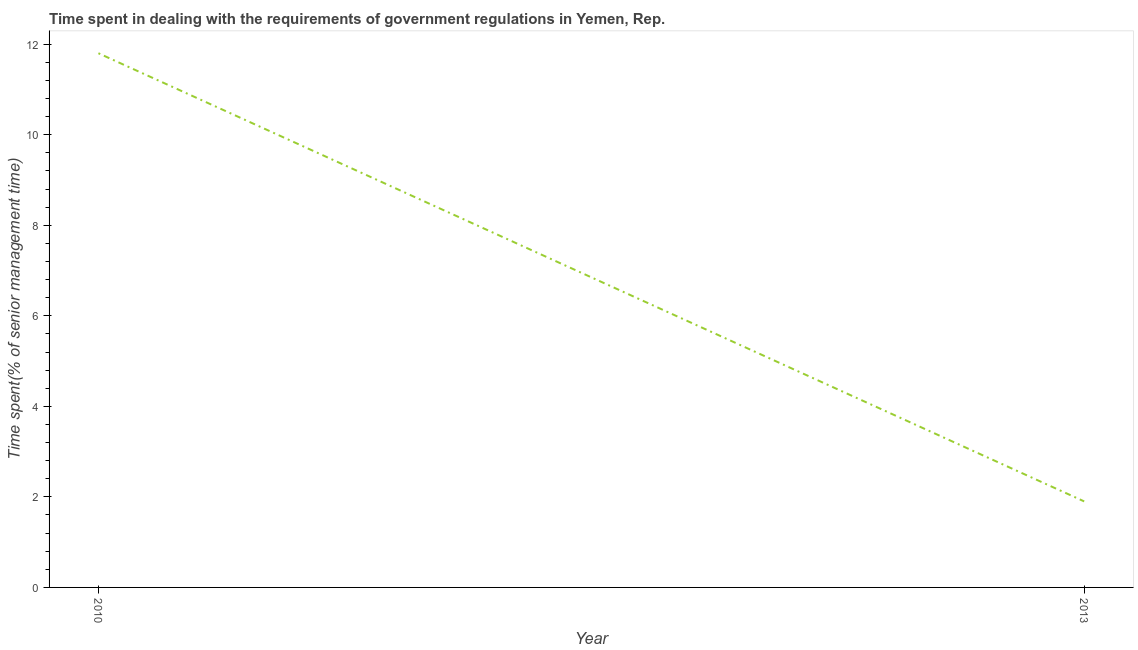

In [114]:
Image.open("../plotqa/png/"+ str(index) +".png")

In [115]:
def erase_files(path):

    for filename in os.listdir(path):

        file_path = os.path.join(path, filename)

        try:
            if os.path.isfile(file_path): os.remove(file_path)
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")

def copy_file(filename, src_dir, dest_dir):
    
    source_path = os.path.join(src_dir, filename)
    destination_path = os.path.join(dest_dir,filename)

    if os.path.exists(source_path):
        try:
            shutil.copy(source_path, destination_path)
        except IOError as e:
            print(f"Failed to copy {filename}: {e}")
    else:
        print(f"File {filename} does not exist in the source directory.")

def generate_split(path, df, indexes):
    
    print("generating slice of size ", len(indexes))
    erase_files(path)

    metadata = [['file_name','text']]

    for i in indexes:
        
        copy_file(str(i) + ".png", "../plotqa/png", path)

        vega_str = '"' + str(get_vega2(df, i, vega_structure = False)) + '"'
        metadata.append([str(i) + ".png", vega_str])

    np.savetxt(path + "/metadata.csv", metadata, delimiter = ',', fmt = '% s')

def generate_dataset(path, df, n_samples):
    
    np.random.seed(42)
    random.seed(42)

    n_train = n_samples
    n_val = int(n_samples * 0.02)
    n_test = int(n_samples)

    indexes = list(df.sample(n_train + n_val + n_test).index)

    generate_split(path + "/train", df, indexes[:n_train])
    generate_split(path + "/val", df, indexes[n_train:n_train+n_val])
    generate_split(path + "/test", df, indexes[n_train+n_val:])

    return indexes

**Dataset Generation**

In [116]:
dataset_name = "plotqa_simple_2"
indexes = generate_dataset("datasets/" + dataset_name, plots, n_samples = 1000)

generating slice of size  1000
generating slice of size  20
generating slice of size  1000


**Upload to Huggingface**

In [117]:
dataset = load_dataset("imagefolder", data_dir = "datasets/" + dataset_name)
dataset.push_to_hub("martinsinnona/" + dataset_name)

Resolving data files:   0%|          | 0/1001 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1001 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/martinsinnona/plotqa_simple_2/commit/40f284409eebb201497c8573ee84c98653d40449', commit_message='Upload dataset', commit_description='', oid='40f284409eebb201497c8573ee84c98653d40449', pr_url=None, pr_revision=None, pr_num=None)

**Análisis de las combinaciones de variables en PlotQA**

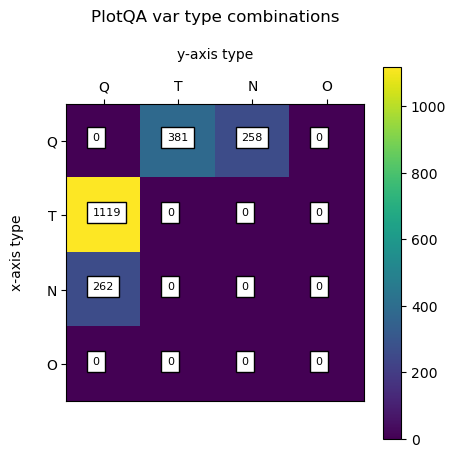

In [118]:
var_types = np.zeros((4,4))
types_map = {"quantitative" : 0, "temporal" : 1, "nominal" : 2, "ordinal" : 3}

for i in indexes:

    vega = get_vega2(plots, i)

    x_type = vega["encoding"]["x"]["type"]
    y_type = vega["encoding"]["y"]["type"]

    var_types[types_map[x_type]][types_map[y_type]] += 1

plt.matshow(var_types)

for x in range(4):
    for y in range(4):
        plt.text(x - 0.15, y, f"{var_types[y,x]:0.00f}", fontsize = 8, c="black", bbox=dict(facecolor='white'))

plt.title("PlotQA var type combinations\n")
plt.xticks([0,1,2,3],["Q","T","N","O"])
plt.yticks([0,1,2,3],["Q","T","N","O"])
plt.ylabel("x-axis type\n")
plt.gca().xaxis.set_label_position('top')  
plt.gca().xaxis.tick_top() 
plt.xlabel("y-axis type\n")
plt.colorbar()

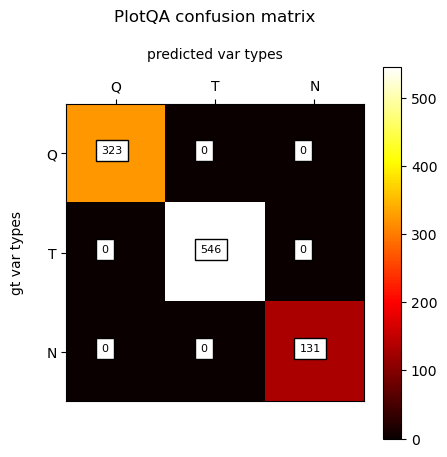

In [8]:
plotQA_confusion = np.array([[323,0,0],
                      [0,546,0],
                      [0,0,131]])

plt.matshow(plotQA_confusion, cmap = "hot")

for x in range(3):
    for y in range(3):
        plt.text(x - 0.15, y, f"{plotQA_confusion[y,x]:0.00f}", fontsize = 8, c="black", bbox=dict(facecolor='white'))

plt.title("PlotQA confusion matrix\n")
plt.xticks([0,1,2],["Q","T","N"])
plt.yticks([0,1,2],["Q","T","N"])
plt.ylabel("gt var types\n")
plt.gca().xaxis.set_label_position('top')  
plt.gca().xaxis.tick_top() 
plt.xlabel("predicted var types\n")
plt.colorbar()

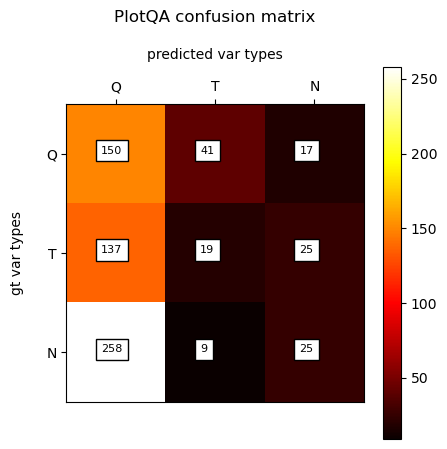

In [9]:
visdecode_confusion = np.array([[150,41,17],
                             [137,19,25],
                             [258,9,25]])



plt.matshow(visdecode_confusion, cmap = "hot")

for x in range(3):
    for y in range(3):
        plt.text(x - 0.15, y, f"{visdecode_confusion[y,x]:0.00f}", fontsize = 8, c="black", bbox=dict(facecolor='white'))

plt.title("PlotQA confusion matrix\n")
plt.xticks([0,1,2],["Q","T","N"])
plt.yticks([0,1,2],["Q","T","N"])
plt.ylabel("gt var types\n")
plt.gca().xaxis.set_label_position('top')  
plt.gca().xaxis.tick_top() 
plt.xlabel("predicted var types\n")
plt.colorbar()